In [67]:
# Trabajo de Final de Grado, Grado en Física, 2022-2023
# Redes Neuronales Hamiltonianas
# Péndulo doble
# Francisco Jesús Frías Tenza

import warnings

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.integrate import solve_ivp

import autograd
import autograd.numpy as np

import argparse
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf

import pandas as pd

In [68]:
global system_config
system_config = {"m1": 1,
                 "l1": 1,
                 "m2": 1,
                 "l2": 1,
                 "g": 10,}

TASA_DE_APRENDIZAJE = 0.001       
CICLOS = 3000               
DIM_OCULTA = 200      

In [69]:
def IdealPendulumHam(coords: np.ndarray) -> float:
    """
    Esta función es el hamiltoniano analítico del sistema de un doble péndulo

    INPUT
    -----
    coords
        array con q, p para cada cuerpo. Las filas son las coordenadas (qx, qy, qz, px, py, pz).
    system_config
        diccionario con los parámetros del sistema, masa, constante elástica, etc.
    """
    q1, q2, p1, p2 = np.split(coords, 4)
    m1, l1 = system_config['m1'], system_config['l1']
    m2, l2 = system_config['m2'], system_config['l2']
    g = system_config['g']
    # p1 = (m_1 + m_2) l_1^2 \dot{\theta_1} + m_2 l_1 l_2 \dot{\theta_2} \cos{(\theta_1 - \theta_2)}
    # p2 = m_2 l_2^2 \dot{\theta_2} + m_2 l_1 l_2 \dot{\theta_1} \cos{(\theta_1 - \theta_2)}
    T = (l2**2 * m2 * p2**2 + l1**2 * (m1 + m2) * p1**2 - 2 * m2 * l1 * l2 * p1 * p2 * np.cos(q1 - q2)) / (2 * l1**2 * l2**2 * m2 * (m1 + m2 * np.sin(q1 - q2)**2)   )
    U = - (m1 + m2) * l1 * g * np.cos(q1) - m2 * g * l2 * np.cos(q2) 
    return T + U

In [70]:
def SympGrad(t, coords):
    """
    gradiente simpléctico
    """
    dham = autograd.grad(IdealPendulumHam)(coords)
    deg_of_frdm = dham.shape[0] // 2
    I = np.identity(deg_of_frdm)
    O = np.zeros((deg_of_frdm, deg_of_frdm))
    S = np.concatenate([np.concatenate((O, I), axis=1), np.concatenate((-I, O), axis=1)], axis=0) @ dham 
    return S

In [71]:
def trayectoria(t_final: float, t_inicio: float, dt: float, y0: np.ndarray) -> np.ndarray:
    r"""
    Tomando las ecuaciones de Hamilton $\frac{dq}{dt} = \frac{dH}{dp}$ y $\frac{dq}{dt} = \frac{dH}{dp}$
    vamos a interpretarlas como un sistema de ecuaciones diferenciales del tipo dy/dt = f(x,y,t) sobre las 
    que hay que integrar numericamente. Emplearemos el metodo Runge-Kutta de orden 4 para obtener q(t+dt), p(d+dt).
    h es salto temporal, que va a ser el mismo para las coordenadas.
    """
    N = int((t_final - t_inicio) / dt)
    t_space = np.linspace(t_inicio, t_final, N)

    solu = solve_ivp(fun=SympGrad, t_span=(t_inicio, t_final), y0=y0, t_eval=t_space, atol=1e-5, rtol=1e-5)
    y = solu.y
    q1, q2, p1, p2 = y[0,:], y[1,:], y[2,:], y[3,:]
    coords = y.copy()
    dcoords_dt = np.empty((y.shape[0], N))
    for i in range(0, N):
        dcoords_dt[:,i] = SympGrad(t=None, coords=coords[:,i])
    dq1dt, dq2dt, dp1dt, dp2dt = dcoords_dt[0,:], dcoords_dt[1,:], dcoords_dt[2,:], dcoords_dt[3,:] 

    return q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_space, dt

In [72]:
def generate_dataset(semilla=1, muestras=100, test_split=0.7, ruido=0.1, **kwargs):

    # muestreamos inpus y outputs aleatorios
    np.random.seed(semilla)
    q1_data, p1_data, dq1dt_data, dp1dt_data = [], [], [], []
    q2_data, p2_data, dq2dt_data, dp2dt_data = [], [], [], []
    t_final = np.random.uniform(0, 10)
    for _ in range(muestras):
        y0 = np.random.rand(4) * np.pi/2 # generar semillas iniciales aleatorias
        #print(t_final)
        q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_space, dt = trayectoria(t_final=t_final, t_inicio=0, dt = 0.1, y0=y0)
        q1 += np.random.randn(*q1.shape)*ruido
        p1 += np.random.randn(*p1.shape)*ruido
        q2 += np.random.randn(*q2.shape)*ruido
        p2 += np.random.randn(*p2.shape)*ruido
        dq1dt += np.random.randn(*dq1dt.shape)*ruido
        dp1dt += np.random.randn(*dp1dt.shape)*ruido
        dq2dt += np.random.randn(*dq2dt.shape)*ruido
        dp2dt += np.random.randn(*dp2dt.shape)*ruido
        #print(q, p, dq, dp)
        #print(q.shape if _ == 1 else pass)
        q1_data.append(q1); p1_data.append(p1)
        dq1dt_data.append(dq1dt); dp1dt_data.append(dp1dt)
        q2_data.append(q2); p2_data.append(p2)
        dq2dt_data.append(dq2dt); dp2dt_data.append(dp2dt)
    
    split_data = {
        "q1": np.concatenate(q1_data, axis=-1),  # X set
        "q2": np.concatenate(q2_data, axis=-1),  # X set

        "p1": np.concatenate(p1_data, axis=-1),
        "p2": np.concatenate(p2_data, axis=-1),

        "dq1": np.concatenate(dq1dt_data, axis=-1), # Y set
        "dq2": np.concatenate(dq2dt_data, axis=-1), # Y set

        "dp1": np.concatenate(dp1dt_data, axis=-1),
        "dp2": np.concatenate(dp2dt_data, axis=-1),
    }

    df = pd.DataFrame.from_dict(split_data, orient='columns')
    df.dropna(axis=0, how='any', inplace=True)

    return df

In [73]:
def get_field(xmin=-2, xmax=2, ymin=-2, ymax=2, gridsize=20):
    y_grid, x_grid = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    dx1dt = np.empty_like(y_grid)
    dy1dt = np.empty_like(x_grid)
    dx2dt = np.empty_like(y_grid)
    dy2dt = np.empty_like(x_grid)
    for j, y in enumerate(np.linspace(ymin, ymax, gridsize)):
        for i, x in enumerate(np.linspace(xmin, xmax, gridsize)):
            aux = SympGrad(t=None, coords=np.array([x,y,x,y]))
            dx1dt[i,j], dy1dt[i,j], dx2dt[i,j], dy2dt[i,j] = aux[0], aux[1], aux[2], aux[3] 
    return x_grid, y_grid, dx1dt, dy1dt, dx2dt, dy2dt

def plot_figures_compare(q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_space, dt):

    x_grid, y_grid, dx1dt, dy1dt, dx2dt, dy2dt = get_field(gridsize=15)

    N = len(q1)
    color = mlp.colormaps['Reds']
    color_aux = mlp.colormaps['Blues']
    color_ranges_p1 = np.sqrt(p1[::10]**2/2 + q1[::10]**2/2)
    color_ranges_p2 = np.sqrt(p2[::10]**2/2 + q2[::10]**2/2)

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
    fig.set_size_inches(w=11, h=11)
    fig.tight_layout(pad=6.5)
    ax1_twinx = ax1.twinx()
    ax4_twinx = ax4.twinx()

    ax1.plot(t_space, q1, "r-", label=r"$q_1(t)$")
    ax1.set_ylabel('Posición (m)', )
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(colors='red', axis='y')

    ax1_twinx.plot(t_space, p1, "b-", label=r"$p_1(t)$")  
    ax1.set_xlabel('Tiempo (s)')
    ax1_twinx.set_ylabel('Velocidad (m/s)')
    ax1_twinx.xaxis.label.set_color('black')
    ax1_twinx.yaxis.label.set_color('blue')
    ax1_twinx.tick_params(colors='blue', axis='y')
    #ax1.legend(bbox_to_anchor=(0.75, 1.2))
    #ax1_twinx.legend(bbox_to_anchor=(0.95, 1.2))

    #ax2.scatter(q[::10], p[::10], c=np.sqrt(p[::10]**2 + q[::10]**2), cmap=color, label="Espacio de Fase")
    ax2.quiver(x_grid, y_grid, dx1dt, dy1dt, cmap='bwr', label=r"Espacio de fases")
    ax2.set_xlabel(r"$\theta_1$")
    ax2.set_ylabel(r"$p_\theta1$")
    ax2.legend(bbox_to_anchor=(0.95, 1.15))
    #ax2.set_xlim(-20, 10)

    ax3.scatter(q1[::10], p1[::10], s=5, c=color_ranges_p1, cmap=color, 
                norm=colors.CenteredNorm(vcenter=color_ranges_p1.max()/2,
                                         halfrange=color_ranges_p1.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
                label="Resultado numérico pendulo 1")
    #ax4.scatter(np.cos(t_space[::10]), -np.sin(t_space[::10]), s=1.5, c=color_ranges, cmap=color_aux, 
    #            norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
    #                                     halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
    #            label="Resultado analítico")
    #ax4.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5), alpha=0.5)
    ax3.set_xlabel(r"$\theta_1$")
    ax3.legend(loc='upper right')
    ax3.set_ylabel(r"$p_\theta1$")
    #ax3.set_xlim((-2, 2))
    #ax3.set_ylim((-4, 4))

    ax4.plot(t_space, q2, "r-", label=r"$q_2(t)$")
    ax4.set_ylabel('Posición (m)', )
    ax4.xaxis.label.set_color('black')
    ax4.yaxis.label.set_color('red')
    ax4.tick_params(colors='red', axis='y')

    ax4_twinx.plot(t_space, p2, "b-", label=r"$p_2(t)$")  
    ax4.set_xlabel('Tiempo (s)')
    ax4_twinx.set_ylabel('Velocidad (m/s)')
    ax4_twinx.xaxis.label.set_color('black')
    ax4_twinx.yaxis.label.set_color('blue')
    ax4_twinx.tick_params(colors='blue', axis='y')
    #ax4.legend(bbox_to_anchor=(0.75, 1.2))
    #ax4_twinx.legend(bbox_to_anchor=(0.95, 1.2))

    #ax2.scatter(q[::10], p[::10], c=np.sqrt(p[::10]**2 + q[::10]**2), cmap=color, label="Espacio de Fase")
    ax5.quiver(x_grid, y_grid, dx2dt, dy2dt, cmap='bwr', label=r"Espacio de fases")
    ax5.set_xlabel(r"$\theta_2$")
    ax5.set_ylabel(r"$p_\theta2$")
    ax5.legend(bbox_to_anchor=(0.95, 1.15))
    #ax5.set_xlim(-20, 10)

    ax6.scatter(q2[::10], p2[::10], s=5, c=color_ranges_p2, cmap=color, 
                norm=colors.CenteredNorm(vcenter=color_ranges_p2.max()/2,
                                         halfrange=color_ranges_p2.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
                label="Resultado numérico pendulo 2")
    #ax4.scatter(np.cos(t_space[::10]), -np.sin(t_space[::10]), s=1.5, c=color_ranges, cmap=color_aux, 
    #            norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
    #                                     halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
    #            label="Resultado analítico")
    #ax4.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5), alpha=0.5)
    ax6.set_xlabel(r"$\theta_2$")
    ax6.legend(loc='upper right')
    ax6.set_ylabel(r"$p_\theta2$")
    #ax6.set_xlim((-2, 2))
    #ax6.set_ylim((-4, 4))

    fig.savefig(r".\img\dob_pen_{}_{}".format(*map(lambda x: int(x[0]), [q1, p1, q2, p2])) )

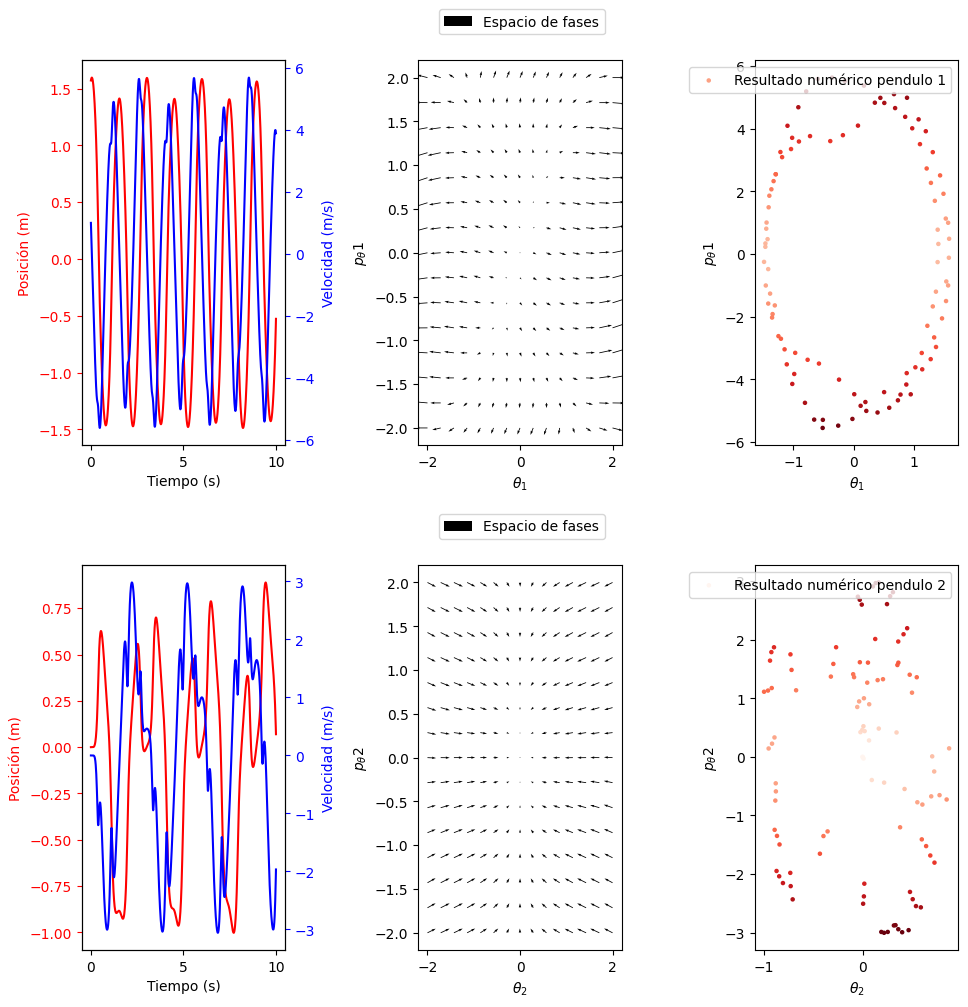

In [74]:
plot_figures_compare(*trayectoria(t_final=10, t_inicio=0, dt=0.01, y0=np.array([np.pi/2,0,1,0])))

In [75]:
class HNN(tf.Module):
  
  def __init__(self, dim_entrada, dim_oculta, name=None):
    super().__init__(name=name)
    self.dim_entrada = dim_entrada
    self.dim_oculta = dim_oculta
    self.capa1 = tf.keras.layers.InputLayer(input_shape=self.dim_entrada) # Input layer
    self.capa2 = tf.keras.layers.Dense(units=self.dim_oculta, activation='tanh')
    # Si se busca crear más capas, ha de copiarse y pegar el siguiente código
    # self.capa_n = tf.keras.layers.Dense(units=dim_oculta, activation='tanh') # donde "_n" es u numero natural
    self.capa4 = tf.keras.layers.Dense(1) # Output layer
    O = np.zeros((dim_entrada//2, dim_entrada//2))
    I = np.identity(dim_entrada//2)
    R_90 = np.concatenate([np.concatenate((O, I), axis=1), np.concatenate((-I, O), axis=1)], axis=0)
    self.R_90 = tf.constant(R_90, dtype='double')

  @tf.Module.with_name_scope
  def __call__(self, x):
    y = self.capa1(x)
    y = self.capa2(y)
    y = self.capa4(y)
    return y
  
  def compute_symplectic_gradient(self, x):
    with tf.GradientTape() as tape:
      y = self.capa1(x)
      y = self.capa2(y)
      y = self.capa4(y)
    y = tape.gradient(y, x)
    y = y @ tf.constant(np.linalg.inv(self.R_90), dtype='double')
    return y
  
  def entrenar_HNN(self, data, tasa_de_aprendizaje = TASA_DE_APRENDIZAJE, ciclos = CICLOS):
    warnings.filterwarnings('ignore')
    loss_array = np.zeros(ciclos+1)
    # Tomamos el algoritmo Adam para optimización
    adam_aldoritmo = tf.keras.optimizers.Adam(learning_rate=tasa_de_aprendizaje)
    # Declaramos la función de coste
    funcion_coste_L2 = tf.keras.losses.MeanSquaredError()
    ciclo = 0
    while ciclo <= ciclos:
        with tf.GradientTape() as tape_coste: # Este es el gradiente de la función de coste
            tape_coste.watch(self.trainable_variables) # Esto nos permite 'vigilar' las variables de TensorFlow
            y_train_keys = [key for key in data.columns if 'd' in key]
            y_test_keys = [key for key in data.columns if 'd' not in key]
            #print(y_train_keys, y_test_keys)
            y_pred = self.compute_symplectic_gradient(tf.Variable(tf.stack(data[y_test_keys]))) # SympGrad del Hamiltoniano
            y_real = tf.Variable(tf.stack(data[y_train_keys]))
            loss = funcion_coste_L2(y_pred=y_pred, y_true=y_real) # Evaluación de la función de coste
        # Creamos el gradiente
        gradiente_funcion_coste_L2 = tape_coste.gradient(loss, self.trainable_variables)
        # El siguiente paso es opcional, usamos esto para agilizar el entrenamiento
        adam_aldoritmo.apply_gradients(zip(gradiente_funcion_coste_L2, self.trainable_variables))
        print(ciclo, loss)
        loss_array[ciclo] = loss
        ciclo += 1
    warnings.resetwarnings()

    return loss_array

  def integrar_HNN(self, **kwargs):
    return solve_ivp(fun=lambda t, x: self.compute_symplectic_gradient(tf.Variable(tf.reshape(x, (1, self.dim_entrada)), dtype='double')), **kwargs)

In [77]:
hnn_modelo = HNN(dim_entrada=4, dim_oculta=DIM_OCULTA)
loss = hnn_modelo.entrenar_HNN(data=generate_dataset(), tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

0 tf.Tensor(38.621536240151386, shape=(), dtype=float64)
1 tf.Tensor(38.60023658548002, shape=(), dtype=float64)
2 tf.Tensor(38.579633896391066, shape=(), dtype=float64)
3 tf.Tensor(38.55973163233502, shape=(), dtype=float64)
4 tf.Tensor(38.54052710387988, shape=(), dtype=float64)
5 tf.Tensor(38.52201360396618, shape=(), dtype=float64)
6 tf.Tensor(38.50418359086786, shape=(), dtype=float64)
7 tf.Tensor(38.48702834444302, shape=(), dtype=float64)
8 tf.Tensor(38.470536518503444, shape=(), dtype=float64)
9 tf.Tensor(38.454693584027254, shape=(), dtype=float64)
10 tf.Tensor(38.43948213760996, shape=(), dtype=float64)
11 tf.Tensor(38.42488202761767, shape=(), dtype=float64)
12 tf.Tensor(38.41087090203584, shape=(), dtype=float64)
13 tf.Tensor(38.397424420854634, shape=(), dtype=float64)
14 tf.Tensor(38.38451666217238, shape=(), dtype=float64)
15 tf.Tensor(38.37212032689923, shape=(), dtype=float64)
16 tf.Tensor(38.36020697539739, shape=(), dtype=float64)
17 tf.Tensor(38.34874729365322, shap

In [78]:
t_span = [0,10]
t_puntos = 2000
t_eval = np.linspace(t_span[0], t_span[1], t_puntos)
atol = 1e-9; rtol = 1e-9
y0 = np.array([np.pi/2-0.01, np.pi/2, 0, 0 ])
kwargs = {'y0': y0, 't_span': t_span, 't_eval': t_eval, 'rtol': rtol, 'atol': atol}
hnn_trayectoria = hnn_modelo.integrar_HNN(**kwargs)

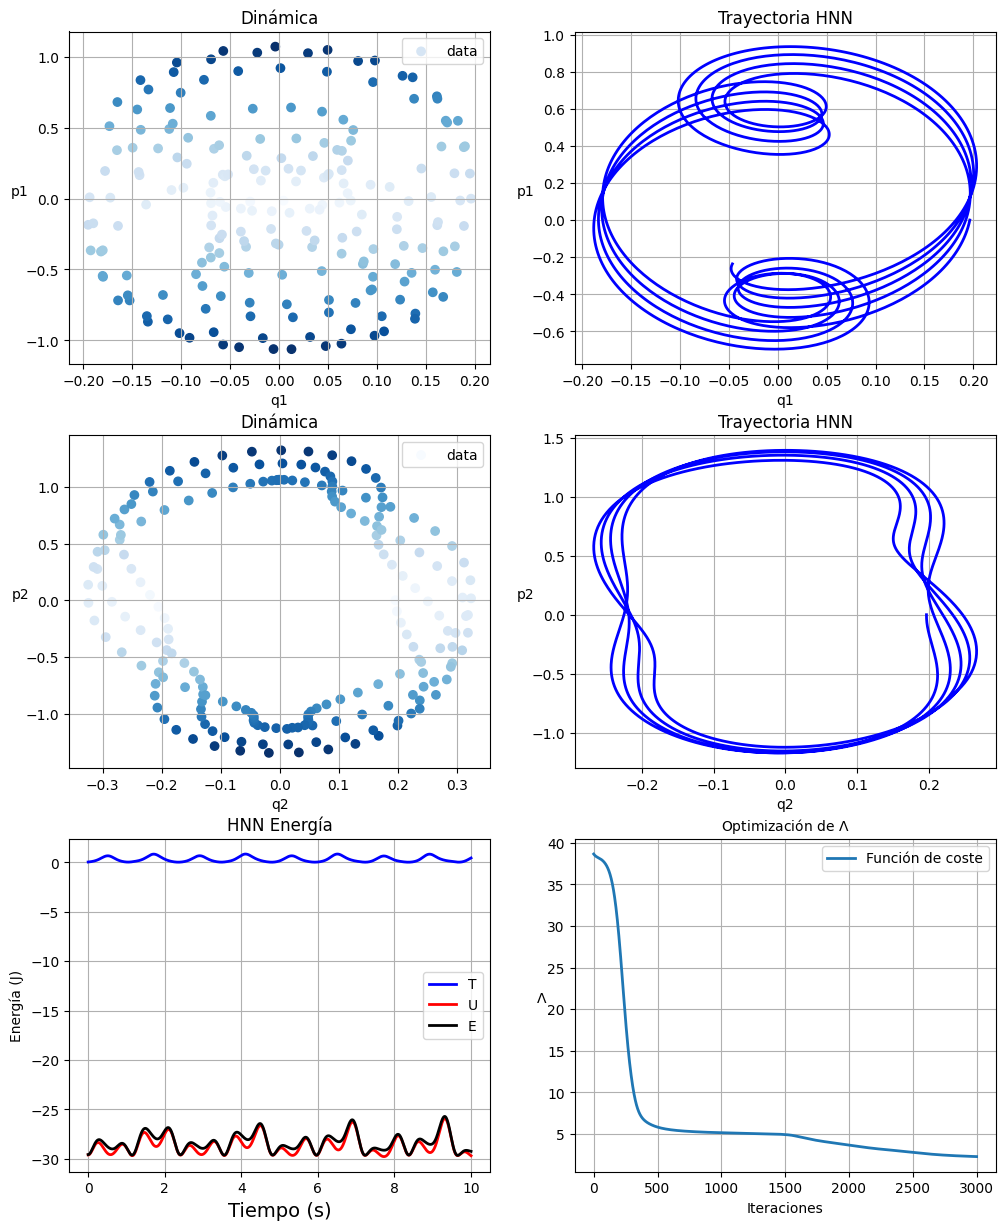

In [86]:
def T(p1, p2, x1, x2, system_config):
    l1, l2 = system_config['l1'], system_config['l2']
    m1, m2 = system_config['m1'], system_config['m2']
    g = system_config['g']

    t1 = l2 ** 2 * m2 * p2 ** 2 + l1 ** 2 * (m1 + m2) * p1**2 - 2 * m2 * l1 * l2 * p1 * p2 * np.cos(x1 - x2)
    t2 = 2 * l1 ** 2 * l2 ** 2 * m2 * (m1 + m2 * np.sin(x1 - x2)**2)
    return t1 / t2 # (l2**2 * m2 * p2**2 + l1**2 * (m1 + m2) * p1**2 - 2 * m2 * l1 * l2 * p1 * p2 * np.cos(q1 - q2)) / (2 * l1**2 * l2**2 * m2 * (m1 + m2 * np.sin(q1 - q2)**2)   )

def U(x1, x2, system_config):
    u1 = (system_config['m1'] + system_config['m2']) * system_config['g'] * system_config['l1'] * np.cos(x1)
    u2 = system_config['m2'] * system_config['g'] * system_config['l2'] * np.cos(x2)
    return - u1 - u2 #(m1 + m2) * l1 * g * np.cos(q1) - m2 * g * l2 * np.cos(q2)

color = mlp.colormaps['Blues']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(10, 12)
fig.tight_layout(pad=1.1, h_pad=3, w_pad=3)

q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_space, dt = trayectoria(t_final=t_span[1], t_inicio=t_span[0], dt=(t_span[1]-t_span[0])/t_puntos, y0=y0)

ax1.scatter(q1[::10], p1[::10], c=np.sqrt(q1[::10]**2 + p1[::10]**2), cmap=color, label='data')
ax1.set_xlabel("q1", fontsize=10)
ax1.set_ylabel("p1", rotation=0, fontsize=10)
ax1.set_title("Dinámica")
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], color='b', linewidth=2)    
ax2.set_xlabel("q1", fontsize=10)
ax2.set_ylabel("p1", rotation=0, fontsize=10)
ax2.set_title("Trayectoria HNN")
ax2.grid()

ax3.scatter(q2[::10], p2[::10], c=np.sqrt(q2[::10]**2 + p2[::10]**2), cmap=color, label='data')
ax3.set_xlabel("q2", fontsize=10)
ax3.set_ylabel("p2", rotation=0, fontsize=10)
ax3.set_title("Dinámica")
ax3.legend(loc='upper right')
ax3.grid()

ax4.plot(hnn_trayectoria['y'].T[:,1], hnn_trayectoria['y'].T[:,3], color='b', linewidth=2)    
ax4.set_xlabel("q2", fontsize=10)
ax4.set_ylabel("p2", rotation=0, fontsize=10)
ax4.set_title("Trayectoria HNN")
ax4.grid()

U_energias = U(hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], system_config)
T_energias = T(hnn_trayectoria['y'].T[:,1], hnn_trayectoria['y'].T[:,3], hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], system_config) 
E_energias = T_energias + U_energias

ax5.plot(t_space, T_energias, color='b', linewidth=2, label="T")
ax5.plot(t_space, U_energias, color='r', linewidth=2, label="U")
ax5.plot(t_space, E_energias, color='k', linewidth=2, label="E")    
ax5.set_xlabel("Tiempo (s)", fontsize=10)
ax5.set_ylabel("Energía (J)", rotation=90, fontsize=10)
ax5.set_title("HNN Energía")
ax5.legend()
ax5.grid()

ax6.plot(np.arange(len(loss)), loss, linewidth=2, label="Función de coste")    
ax6.set_xlabel("Iteraciones", fontsize=10)
ax6.set_ylabel(r"$\Lambda$", rotation=0, fontsize=10)
ax6.set_title(r"Optimización de $\Lambda$")
ax6.legend()
ax6.grid()

plt.savefig(r".\img\dob_pen_hnn_pred_{}_{}.png".format(4, 2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


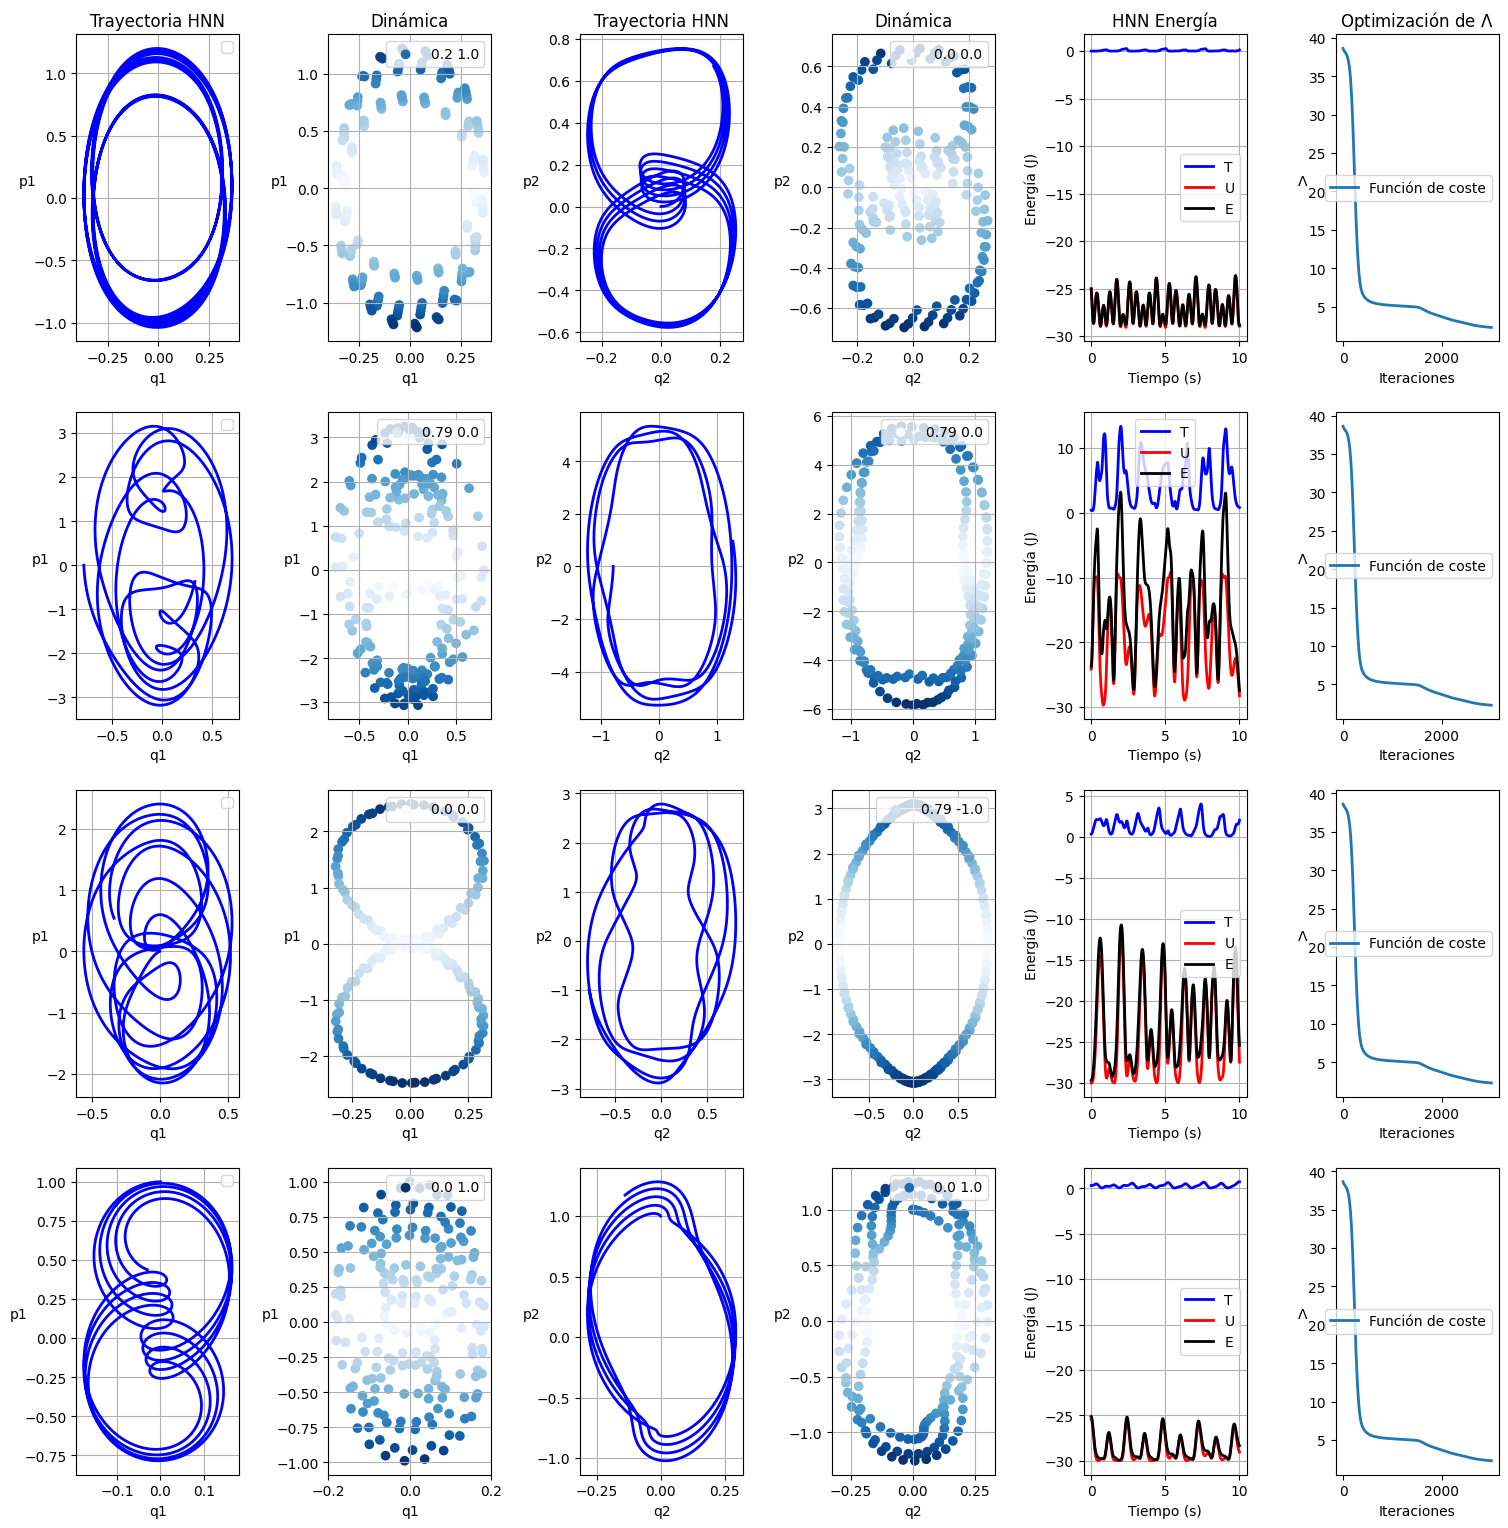

In [87]:
ys0 = np.array([[np.pi/16, 0, 1, 0 ],
                [np.pi/4, np.pi/4, 0, 0 ],
                [0, np.pi/4, 0, -1],
                [0, 0, 1, 1]])

fig, axs = plt.subplots(nrows=4, ncols=6)
fig.set_size_inches(15 ,15)
fig.tight_layout()
fig.tight_layout(pad=1.1, h_pad=3, w_pad=3)

for i, y0 in enumerate(ys0):

    q1, q2, p1, p2, dq1dt, dq2dt, dp1dt, dp2dt, t_space, dt = trayectoria(t_final=t_span[1], t_inicio=t_span[0], dt=(t_span[1]-t_span[0])/t_puntos, y0=y0)
    kwargs = {'y0': y0, 't_span': t_span, 't_eval': t_eval, 'rtol': rtol, 'atol': atol}
    hnn_trayectoria = hnn_modelo.integrar_HNN(**kwargs)

    axs[i,0].plot(-hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], color='b', linewidth=2)
    axs[i,0].set_xlabel("q1", fontsize=10)
    axs[i,0].set_ylabel("p1", rotation=0, fontsize=10)
    if i == 0:
        axs[i,0].set_title("Trayectoria HNN")
    axs[i,0].legend(loc='upper right')
    axs[i,0].grid()

    axs[i,1].scatter(q1[::10], p1[::10], c=np.sqrt(q1[::10]**2 + p1[::10]**2), cmap=color, label=" ".join([str(round(y, 2)) for y in y0[::2]]))
    axs[i,1].set_xlabel("q1", fontsize=10)
    axs[i,1].set_ylabel("p1", rotation=0, fontsize=10)
    if i == 0:
        axs[i,1].set_title("Dinámica")
    axs[i,1].legend(loc='upper right')
    axs[i,1].grid()

    axs[i,2].plot(-hnn_trayectoria['y'].T[:,1], hnn_trayectoria['y'].T[:,3], color='b', linewidth=2)    
    axs[i,2].set_xlabel("q2", fontsize=10)
    axs[i,2].set_ylabel("p2", rotation=0, fontsize=10)
    if i == 0:
        axs[i,2].set_title("Trayectoria HNN")
    axs[i,2].grid()

    axs[i,3].scatter(q2[::10], p2[::10], c=np.sqrt(q2[::10]**2 + p2[::10]**2), cmap=color, label=" ".join([str(round(y, 2)) for y in y0[1::2]]))
    axs[i,3].set_xlabel("q2", fontsize=10)
    axs[i,3].set_ylabel("p2", rotation=0, fontsize=10)   
    if i == 0:
        axs[i,3].set_title("Dinámica")
    axs[i,3].legend(loc='upper right')
    axs[i,3].grid()

    U_energias = U(-hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], system_config)
    T_energias = T(-hnn_trayectoria['y'].T[:,1], hnn_trayectoria['y'].T[:,3], -hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,2], system_config) 
    E_energias = T_energias + U_energias

    axs[i,4].plot(t_space, T_energias, color='b', linewidth=2, label="T")
    axs[i,4].plot(t_space, U_energias, color='r', linewidth=2, label="U")
    axs[i,4].plot(t_space, E_energias, color='k', linewidth=2, label="E")    
    axs[i,4].set_xlabel("Tiempo (s)", fontsize=10)
    axs[i,4].set_ylabel("Energía (J)", rotation=90, fontsize=10)
    if i == 0:
        axs[i,4].set_title("HNN Energía")
    axs[i,4].legend()
    axs[i,4].grid()

    axs[i,5].plot(np.arange(len(loss)), loss, linewidth=2, label="Función de coste")    
    axs[i,5].set_xlabel("Iteraciones", fontsize=10)
    axs[i,5].set_ylabel(r"$\Lambda$", rotation=0, fontsize=10)
    if i == 0:
        axs[i,5].set_title(r"Optimización de $\Lambda$")
    axs[i,5].legend()

plt.savefig(r".\img\many_dob_pen_hnn_pred_4_4.png")